In [21]:
#Importowanie bibliotek
import os
import numpy as np
import cv2
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import h5py
import imageio
import gc
import time
from tensorflow.keras.layers import Input,Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Reshape,LeakyReLU,BatchNormalization,Conv2DTranspose,Add,PReLU,Concatenate,Add,Average,ZeroPadding2D,Lambda,Dropout,AveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam,RMSprop,Adadelta,SGD,Adagrad,Nadam,Adamax
from keras.initializers import RandomNormal
from tensorflow.keras.models import load_model,Model,Sequential
from tensorflow.keras.preprocessing import image,image_dataset_from_directory
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.applications.vgg19 import preprocess_input
from PIL import Image
from tensorflow.keras.applications import VGG19,VGG16
from skimage.io import imsave
from skimage.util import random_noise
from skimage import color
%matplotlib inline

In [2]:
#Inicializacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
#Ustawienie losowego ziarna aby wyniki były powtarzalne
np.random.seed(42)

In [3]:
#Ścieżka do zbioru treningowego
input_dir='D:/Flickr2K/input/'
label_dir='D:/tempflickr/clear/'

In [4]:
def residual_block(x,filters):
    kernel_size=(3,3)
    strides=1
    padding='same'

    res=tfa.layers.SpectralNormalization(Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding,kernel_initializer='he_uniform'))(x)
    
    res=PReLU(shared_axes=[1,2])(res)
    
    res=tfa.layers.SpectralNormalization(Conv2D(filters,kernel_size=kernel_size,strides=strides,padding=padding))(res)

    res=Add()([res,x])
    return res

def build_generator():
    input=Input(shape=(None,None,3))
    
    bilin1=UpSampling2D((2,2),interpolation='bilinear')(input)
    bilin2=UpSampling2D((2,2),interpolation='bilinear')(bilin1)

    gen1_block1=tfa.layers.SpectralNormalization(Conv2D(32,kernel_size=(3,3),strides=1,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(input)

    gen2_block1=tfa.layers.SpectralNormalization(Conv2D(64,kernel_size=(3,3),strides=2,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(gen1_block1)

    res=residual_block(gen2_block1,64)
    for i in range(8):
        res=residual_block(res,64)

    up1=UpSampling2D((2,2))(res)
    
    gen1_block2=tfa.layers.SpectralNormalization(Conv2D(32,kernel_size=(3,3),strides=1,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(up1)
    
    res2=residual_block(gen1_block2,32)
    for i in range(6):
        res2=residual_block(res2,32)
    
    gen2_block2=tfa.layers.SpectralNormalization(Conv2D(16,kernel_size=(3,3),strides=1,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(res2)
    
    up2=UpSampling2D((2,2),interpolation='bilinear')(gen2_block2)
    
    res3=residual_block(up2,16)
    for i in range(5):
        res3=residual_block(res3,16)
        
    #gen1_block3=tfa.layers.SpectralNormalization(Conv2D(8,kernel_size=(3,3),strides=1,padding='same',activation=LeakyReLU(),kernel_initializer='he_uniform'))(res3)
    
    up3=UpSampling2D((2,2))(res3)
    
    gen1_block3=tfa.layers.SpectralNormalization(Conv2D(8,kernel_size=(3,3),strides=1,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(up3)
    
    res3=residual_block(gen1_block3,8)
    for i in range(4):
        res3=residual_block(res3,8)

    con=Concatenate()([bilin2,res3])
    
    mid=tfa.layers.SpectralNormalization(Conv2D(8,kernel_size=(3,3),strides=1,padding='same',activation=PReLU(shared_axes=[1,2]),kernel_initializer='he_uniform'))(con)

    out=Conv2D(3,kernel_size=(5,5),strides=1,padding='same',activation='tanh',kernel_initializer='glorot_uniform')(mid)
    model=Model(input,out,name='generator')
    return model


In [5]:
#U-Net disc
def encoder_block(layer_in,n_filters,batchnorm=True):
    init=RandomNormal(stddev=0.02)
    g=tfa.layers.SpectralNormalization(Conv2D(n_filters,kernel_size=(3,3),strides=2,padding='same',kernel_initializer=init),power_iterations=2)(layer_in)
    if batchnorm:
        g=BatchNormalization()(g,training=True)
    g=LeakyReLU(0.2)(g)
    return g

def decoder_block(layer_in,skip_in,n_filters,dropout=True):
    init=RandomNormal(stddev=0.02)
    g=Conv2DTranspose(n_filters,kernel_size=(4,4),strides=2,padding='same',kernel_initializer=init)(layer_in)
    g=BatchNormalization()(g,training=True)
    if dropout:
        g=Dropout(0.1)(g,training=True)
    g=Concatenate()([g,skip_in])
    g=Activation(LeakyReLU(0.2))(g)
    return g

def build_discriminator():
    init=RandomNormal(stddev=0.02)
    input=Input(shape=(416,640,3))

    e1=encoder_block(input,64,batchnorm=False)
    e2=encoder_block(e1,128)
    e3=encoder_block(e2,128)
    #e4=encoder_block(e3,128)
    #e5=encoder_block(e4,128)
    b=Conv2D(256,kernel_size=(4,4),activation=LeakyReLU(0.2),strides=2,padding='same',kernel_initializer=init)(e3)
    b=Activation(LeakyReLU(0.2))(b)
    d2=decoder_block(b,e3,128)
    #d3=decoder_block(d2,e4,128)
    #d4=decoder_block(d2,e3,128)
    d5=decoder_block(d2,e2,128,dropout=False)
    d6=decoder_block(d5,e1,64,dropout=False)
    d_out=Conv2DTranspose(1,kernel_size=(4,4),strides=2,activation='sigmoid',padding='same',kernel_initializer=init)(d6)


    model=Model(input,d_out,name='U-Net_Discriminator')
    return model


In [7]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [8]:
#Obliczanie macierzy grama
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [9]:
#Funkcja która ma na celu utrzymanie obrazu referencyjnego w generowanym obrazie. Opiera się na macierzach gramów które rejestrują styl,
#mapy cech z obrazu referencyjnego stylu i z wygenerowanego obrazu.
def style_loss(style,comb):
    S=gram_matrix(style)
    C=gram_matrix(comb)
    channels=3
    size=416*640
    return tf.reduce_sum(tf.square(S-C))/(4.0*(channels **2)*(size**2))

#Funkcja która ma za zadanie obliczenie średniego błędu kwadratowego(l2) obrazów z mapami cech z obrazem referncyjnym.
def content_loss(base,comb):
    return tf.reduce_sum(tf.square(comb-base))
    

In [10]:
#Inicjalizacja przetrenowanej sieci VGG19 
vgg19=VGG19(include_top=False,weights='imagenet',input_shape=(None,None,3))
outputs_dict=dict([(layer.name,layer.output) for layer in vgg19.layers])
feature_extractor=Model(vgg19.inputs,outputs_dict)

In [168]:
#Wybór odpowiednich warstw do transferu stylu 
style_layer_names=['block2_conv2','block3_conv4','block4_conv3','block4_conv4','block5_conv2','block5_conv3']
#Wybór warstwy do perceptual loss, wybór tej warstwy nie jest przypadkowy dlatego, że wykazuje ona najlepszą jakość wizualną.
content_layer_name='block4_conv2'


def compute_loss(base_image,style_image):
    #Wstpne przetwarzanie danych wejściowych do sieci VGG19
    base_image=(base_image+1)*127.5
    style_image=(style_image+1)*127.5
    base_image=preprocess_input(base_image)/127.5
    style_image=preprocess_input(style_image)/127.5
    
    loss = tf.zeros(shape=())
    #Otrzymanie mapy cech z obrazów przy uyżyciu sieci VGG19 i konkretnej warstwy.
    features=feature_extractor(base_image)
    features2=feature_extractor(style_image)
    layer_features=features[content_layer_name]
    layer_features2=features2[content_layer_name]
    loss=loss+1e-4*content_loss(layer_features,layer_features2)
    
    #Transfer stylu z różnych warstw sieci VGG19
    for layer_name in style_layer_names:
        layer_features3=features[layer_name]
        layer_features4=features2[layer_name]
        layer_features3=layer_features3[0,:,:,:]
        layer_features4=layer_features4[0,:,:,:]
        print(layer_features3.shape,layer_features4.shape)
        s1=style_loss(layer_features3,layer_features4)
        loss +=(1e-4/len(style_layer_names))*s1
    
    #Dodanie Total Variation jako funkcji kosztu w celu lepszego pokrycia sieci przeciwstawnych oraz odszumienia obrazu końcowego.
    loss +=1e-7*tf.reduce_mean(tf.image.total_variation(base_image))
    return loss

In [169]:
generator=build_generator()
discriminator=build_discriminator()

In [170]:
generator_optimizer=Adam(learning_rate=0.00006,beta_1=0.9)
discriminator_optimizer=Adam(learning_rate=0.00006,beta_1=0.9)

In [171]:
discriminator.summary()

Model: "U-Net_Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 416, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 spectral_normalization_123 (Sp  (None, 208, 320, 64  1856       ['input_5[0][0]']                
 ectralNormalization)           )                                                                 
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 208, 320, 64  0           ['spectral_normalization_123[0][0
                                )                                ]']            

In [172]:
cross_entropy=tf.keras.losses.BinaryCrossentropy()

#Funkcja kosztu dla dyskriminatora, która określa czy wygenerowany obraz jest jakościowo tak dobry jak obraz referencyjny.
#Razem tworzą adversarial loss, który pomaga zachować lepszą szczegółwość wygenerowanych obrazów przez generator.
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    total_loss=real_loss+fake_loss
    return total_loss

#Funkcja kosztu dla generatora.
def generator_loss(fake):
    return cross_entropy(tf.ones_like(fake),fake)

In [36]:
discriminator.output_shape[1:]

(416, 640, 1)

In [86]:
#Skompilowanie sieci opdowiednimi funkcjami kosztu
discriminator.compile(loss=discriminator_loss,optimizer=Adam(learning_rate=0.00006),metrics=['accuracy'])
discriminator.trainable=False
generator.compile(loss=generator_loss,optimizer=Adam(learning_rate=0.00006),metrics=['mse'])

In [173]:
#W tym miejscu sieć GAN jest trenowana
@tf.function
def train_step(img_input,img_target):
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        #Trenowanie generatora 
        generated=generator(img_input,training=True)
        
        #Trening Dyskriminatora
        real_out=discriminator(img_target,training=True)
        fake_out=discriminator(generated,training=True)
        
        #Obliczenie funkcji kosztu dla dyskryminatora 
        disc_loss=discriminator_loss(real_out,fake_out)
        #Obliczenie funkcji kosztu dla generatora
        gen_loss1=generator_loss(fake_out)
        gen_loss2=compute_loss(img_target,generated)
        total_loss=1e-3*gen_loss1+gen_loss2
    
        #Obliczanie gradientów
        generator_gradients=gen_tape.gradient(total_loss,generator.trainable_variables)
        discriminator_gradients=disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        
        #Zastosowanie odpowiedniego optymalizatora 
        generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
    
    return disc_loss,gen_loss1,gen_loss2
        

In [174]:
#Zwiekszanie różnorodności zbioru danych poprzez różne modyfikacje

#Losowe rozjaśnianie obrazu
def brightness(img,low,high):
    global value_brightness
    value_brightness=random.randint(low,high)
    bright=np.ones(img.shape,dtype=np.uint8)*value_brightness
    brightadd=cv2.add(img,bright)
    return brightadd

#Losowe przyciemnianie obrazu
def darken(img,low,high):
    global value_darken
    value_darken=random.randint(low,high)
    dark=np.ones(img.shape,dtype=np.uint8)*value_darken
    darkadd=cv2.subtract(img,dark)
    return darkadd

#Wypełnienie
def fill(img, h, w):
    img = cv2.resize(img, (w,h), cv2.INTER_AREA)
    return img

#Losowe przycinanie obrazu 
def zoom(img):
    global value_zoom
    global h_start
    global w_start
    value_zoom=random.uniform(0.2,0.7)
    h,w=img.shape[:2]
    h_taken=int(value_zoom*h)
    w_taken=int(value_zoom*w)
    h_start=random.randint(0,h-h_taken)
    w_start=random.randint(0,w-w_taken)
    img=img[h_start:h_start+h_taken,w_start:w_start+w_taken,:]
    img=fill(img,h,w)
    return img

#Odwracanie w poziomie 
def horizontal_flip(img):
    img=cv2.flip(img,1)
    return img

#Losowy szum
def noise(img):
    global var
    var=random.uniform(0.001,0.01)
    noisy=random_noise(img,mode='gaussian',mean=0,var=var)
    noisy=(noisy*255).astype(np.uint8)
    #noisy=img+gauss
    return noisy

def brightness_2(img,value):
    bright=np.ones(img.shape,dtype=np.uint8)*value
    brightadd=cv2.add(img,bright)
    return brightadd

def darken_2(img,value):
    dark=np.ones(img.shape,dtype=np.uint8)*value
    darkadd=cv2.subtract(img,dark)
    return darkadd

def zoom_2(img,value,h_start,w_start):
    h,w=img.shape[:2]
    h_taken=int(value*h)
    w_taken=int(value*w)
    img=img[h_start:h_start+h_taken,w_start:w_start+w_taken,:]
    img=fill(img,h,w)
    return img

def noise_2(img,var):
    noisy=random_noise(img,mode='gaussian',mean=0,var=var)
    noisy=(noisy*255).astype(np.uint8)
    return noisy

In [176]:
def batch_gen(batch_size,input_path,label_path):
    while(1):
        noisy=os.listdir(input_path)
        clear=os.listdir(label_path)
        #img_batches2=np.random.choice(clear,size=batch_size)
        img_batches=np.random.choice(noisy,size=batch_size)
        noisy_images=[]
        draw_mem=[]
        for img in img_batches:
            draw1=np.random.random()
            draw_mem.append(draw1)
            images0=cv2.imread(input_path+img)
            images0=cv2.resize(images0,(160,104),interpolation=cv2.INTER_AREA)
            if draw1 > 0 and draw1<0.165:
                images1=darken(images0,35,90)
                noisy_images.append(images1)
            elif draw1 >0.165 and draw1 <0.33:
                images2=brightness(images0,35,90)
                noisy_images.append(images2)
            elif draw1 > 0.33 and draw1 <0.495:
                images3=noise(images0)
                noisy_images.append(images3)
            elif draw1> 0.495 and draw1<0.66:
                noisy_images.append(images0)
            elif draw1>0.66 and draw1<0.83:
                images4=zoom(images0)
                noisy_images.append(images4)
            elif draw1>0.83 and draw1<0.999:
                images5=horizontal_flip(images0)
                noisy_images.append(images5)
            else:
                noisy_images.append(images0)
        noisy_images=np.array(noisy_images)/127.5-1
        noisy_images=noisy_images.astype('float32')
        clear_images=[]
        i=0
        for img1 in img_batches:
            images=cv2.imread(label_path+img1)
            images=cv2.resize(images,(640,416),interpolation=cv2.INTER_AREA)
            #images=cv2.cvtColor(images,cv2.COLOR_BGR2RGB)
            if draw_mem[i] > 0 and draw_mem[i]<0.165:
                images1=darken_2(images,value_darken)
                clear_images.append(images1)
                i +=1
            elif draw_mem[i] >0.165 and draw_mem[i] <0.33:
                images2=brightness_2(images,value_brightness)
                clear_images.append(images2)
                i +=1
            elif draw_mem[i] > 0.33 and draw_mem[i] <0.495:
                images3=noise_2(images,var)
                clear_images.append(images3)
                i +=1
            elif draw_mem[i]> 0.495 and draw_mem[i]<0.66:
                clear_images.append(images)
                i +=1
            elif draw_mem[i]>0.66 and draw_mem[i]<0.83:
                images4=zoom_2(images,value_zoom,h_start,w_start)
                clear_images.append(images4)
                i +=1
            elif draw_mem[i]>0.83 and draw_mem[i]<0.999:
                images5=horizontal_flip(images)
                clear_images.append(images5)
                i +=1
            else:
                clear_images.append(images)
                i +=1
        clear_images=np.array(clear_images)/127.5-1
        clear_images=clear_images.astype('float32')

        yield(clear_images,noisy_images)

In [177]:
#Funkcja umożliwiająca trenowanie sieci
def train(epochs):
    global lr_img,hr_img,epochs_list,g_loss_list,d_loss_list
    batch_size=4
    batch_generator=batch_gen(batch_size,label_dir,label_dir)
    #batch_discriminator=batch_disc(batch_size,label_dir,label_dir)
    count=0
    start=time.time()
    
    epochs_list,g_loss_list,d_loss_list=[],[],[]
    
    for e in range(epochs):
        e_start=time.time()
        
        gen_loss_list=[]
        disc_loss_list=[]
        total_loss_list=[]
        
        #Użycie funkcji do wczytania danych do pamięci
        hr_img,lr_img=next(batch_generator)
        t=train_step(lr_img,hr_img)
        gen_loss_list.append(t[1])
        disc_loss_list.append(t[0])
        total_loss_list.append(t[2].numpy())
        
        g_loss=sum(gen_loss_list)/len(gen_loss_list)
        d_loss=sum(disc_loss_list)/len(disc_loss_list)
        total_loss_list=sum(total_loss_list)/len(total_loss_list)
        
        g_loss_list.append(g_loss.numpy())
        d_loss_list.append(d_loss.numpy())
        epochs_list.append(e)
        epoch_elapsed=time.time()-e_start
        
        print(f'Epoch: {e+1}, gen_loss: {g_loss}, disc_loss: {d_loss}, single_e_time: {str(hms_string(epoch_elapsed))}','Total loss:',total_loss_list)
        
#Co 15 iteracji zapisuje zdjęcie w folderze do podglądu wygenerowanego zdjęcia przez generator i sprawdzeniu procesu trenowania
        if e%15==0:
            test='C:/Users/komej/test0.jpg'
            im=cv2.imread(test)
            im=cv2.resize(im,(512,336),interpolation=cv2.INTER_AREA)
            #im=cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
            im=np.array(im)/127.5-1
            im=im.astype('float32')
            im=np.expand_dims(im,axis=0)
            sc=generator.predict(im)
            count +=1
            sc=sc[0,:,:,:]
            sc=cv2.cvtColor(sc,cv2.COLOR_BGR2RGB)
            sc=((sc+1)*127.5).astype(np.uint8)
            imsave('C:/Users/komej/train_imgs/'+str(count)+'.jpg',sc)
        elif e%51==0:
            generator.save('C:/Users/komej/temp1.h5')
        

In [178]:
train(3000)

(208, 320, 128) (208, 320, 128)
(104, 160, 256) (104, 160, 256)
(52, 80, 512) (52, 80, 512)
(52, 80, 512) (52, 80, 512)
(26, 40, 512) (26, 40, 512)
(26, 40, 512) (26, 40, 512)
(208, 320, 128) (208, 320, 128)
(104, 160, 256) (104, 160, 256)
(52, 80, 512) (52, 80, 512)
(52, 80, 512) (52, 80, 512)
(26, 40, 512) (26, 40, 512)
(26, 40, 512) (26, 40, 512)
Epoch: 1, gen_loss: 0.7086673974990845, disc_loss: 1.4167428016662598, single_e_time: 0:00:09.62 Total loss: 240699.9375
Epoch: 2, gen_loss: 0.6981344819068909, disc_loss: 1.3716737031936646, single_e_time: 0:00:00.57 Total loss: 139516.75
Epoch: 3, gen_loss: 0.691694974899292, disc_loss: 1.3953362703323364, single_e_time: 0:00:00.55 Total loss: 123363.78125
Epoch: 4, gen_loss: 0.6907331943511963, disc_loss: 1.3922386169433594, single_e_time: 0:00:00.53 Total loss: 143509.34375
Epoch: 5, gen_loss: 0.6897569298744202, disc_loss: 1.3965606689453125, single_e_time: 0:00:00.57 Total loss: 146651.0625
Epoch: 6, gen_loss: 0.6921409964561462, disc

C:\anaconda3\envs\keras\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch: 53, gen_loss: 0.7406468987464905, disc_loss: 1.286137580871582, single_e_time: 0:00:00.58 Total loss: 113623.234375
Epoch: 54, gen_loss: 0.7477098107337952, disc_loss: 1.2590854167938232, single_e_time: 0:00:00.54 Total loss: 117425.375
Epoch: 55, gen_loss: 0.7537412047386169, disc_loss: 1.2566194534301758, single_e_time: 0:00:00.55 Total loss: 86788.46875
Epoch: 56, gen_loss: 0.7530307769775391, disc_loss: 1.31658136844635, single_e_time: 0:00:00.55 Total loss: 86379.765625
Epoch: 57, gen_loss: 0.7529316544532776, disc_loss: 1.2525570392608643, single_e_time: 0:00:00.55 Total loss: 119675.34375
Epoch: 58, gen_loss: 0.7520413994789124, disc_loss: 1.2700111865997314, single_e_time: 0:00:00.58 Total loss: 106261.109375
Epoch: 59, gen_loss: 0.7509527206420898, disc_loss: 1.2737444639205933, single_e_time: 0:00:00.54 Total loss: 90915.1875
Epoch: 60, gen_loss: 0.7588205933570862, disc_loss: 1.2596032619476318, single_e_time: 0:00:00.54 Total loss: 101364.7890625
Epoch: 61, gen_loss:

Epoch: 118, gen_loss: 0.8983116745948792, disc_loss: 1.0688214302062988, single_e_time: 0:00:00.55 Total loss: 91812.6796875
Epoch: 119, gen_loss: 0.883412778377533, disc_loss: 1.0555787086486816, single_e_time: 0:00:00.65 Total loss: 118655.015625
Epoch: 120, gen_loss: 0.9025786519050598, disc_loss: 1.0682344436645508, single_e_time: 0:00:00.58 Total loss: 135970.765625
Epoch: 121, gen_loss: 0.9020450711250305, disc_loss: 1.0419869422912598, single_e_time: 0:00:00.57 Total loss: 110588.765625
Epoch: 122, gen_loss: 0.9027358293533325, disc_loss: 1.0584909915924072, single_e_time: 0:00:00.55 Total loss: 140254.671875
Epoch: 123, gen_loss: 0.9139502048492432, disc_loss: 1.0247548818588257, single_e_time: 0:00:00.55 Total loss: 84786.21875
Epoch: 124, gen_loss: 0.909821629524231, disc_loss: 1.0339512825012207, single_e_time: 0:00:00.58 Total loss: 128428.953125
Epoch: 125, gen_loss: 0.890167236328125, disc_loss: 1.0559390783309937, single_e_time: 0:00:00.53 Total loss: 110204.3515625
Epoc

Epoch: 183, gen_loss: 1.0702487230300903, disc_loss: 0.880002498626709, single_e_time: 0:00:00.58 Total loss: 152205.34375
Epoch: 184, gen_loss: 1.065102458000183, disc_loss: 0.860074520111084, single_e_time: 0:00:00.60 Total loss: 144874.78125
Epoch: 185, gen_loss: 1.0644673109054565, disc_loss: 0.8674521446228027, single_e_time: 0:00:00.62 Total loss: 94824.9375
Epoch: 186, gen_loss: 1.081310749053955, disc_loss: 0.8317277431488037, single_e_time: 0:00:00.62 Total loss: 123396.0859375
Epoch: 187, gen_loss: 1.063124179840088, disc_loss: 0.8702648878097534, single_e_time: 0:00:00.57 Total loss: 116230.359375
Epoch: 188, gen_loss: 1.0633530616760254, disc_loss: 0.8059121370315552, single_e_time: 0:00:00.56 Total loss: 79910.0
Epoch: 189, gen_loss: 1.0792311429977417, disc_loss: 0.8437461256980896, single_e_time: 0:00:00.63 Total loss: 122108.6953125
Epoch: 190, gen_loss: 1.078834056854248, disc_loss: 0.9953863620758057, single_e_time: 0:00:00.55 Total loss: 120836.3671875
Epoch: 191, ge

Epoch: 248, gen_loss: 1.1928138732910156, disc_loss: 0.6968128681182861, single_e_time: 0:00:00.55 Total loss: 103265.578125
Epoch: 249, gen_loss: 1.2118123769760132, disc_loss: 0.6660583019256592, single_e_time: 0:00:00.54 Total loss: 117864.6796875
Epoch: 250, gen_loss: 1.1567583084106445, disc_loss: 0.778671383857727, single_e_time: 0:00:00.60 Total loss: 135354.90625
Epoch: 251, gen_loss: 1.1974115371704102, disc_loss: 0.6832559108734131, single_e_time: 0:00:00.58 Total loss: 145018.796875
Epoch: 252, gen_loss: 1.2038805484771729, disc_loss: 0.699836015701294, single_e_time: 0:00:00.65 Total loss: 116480.0234375
Epoch: 253, gen_loss: 1.2037683725357056, disc_loss: 0.7172205448150635, single_e_time: 0:00:00.58 Total loss: 133514.328125
Epoch: 254, gen_loss: 1.2022979259490967, disc_loss: 0.7016558051109314, single_e_time: 0:00:00.62 Total loss: 133590.171875
Epoch: 255, gen_loss: 1.211730718612671, disc_loss: 0.6748890280723572, single_e_time: 0:00:00.54 Total loss: 77638.1328125
Ep

Epoch: 313, gen_loss: 1.3777226209640503, disc_loss: 0.5603070855140686, single_e_time: 0:00:00.58 Total loss: 120189.6953125
Epoch: 314, gen_loss: 1.3871865272521973, disc_loss: 0.6083968281745911, single_e_time: 0:00:00.55 Total loss: 64239.09765625
Epoch: 315, gen_loss: 1.404036521911621, disc_loss: 0.5707092881202698, single_e_time: 0:00:00.56 Total loss: 83796.765625
Epoch: 316, gen_loss: 1.3620423078536987, disc_loss: 0.584983229637146, single_e_time: 0:00:00.59 Total loss: 77736.3359375
Epoch: 317, gen_loss: 1.2876731157302856, disc_loss: 0.6506114602088928, single_e_time: 0:00:00.63 Total loss: 138120.984375
Epoch: 318, gen_loss: 1.224045991897583, disc_loss: 0.6334174275398254, single_e_time: 0:00:00.61 Total loss: 119815.453125
Epoch: 319, gen_loss: 1.344185471534729, disc_loss: 0.5415635108947754, single_e_time: 0:00:00.59 Total loss: 109203.4375
Epoch: 320, gen_loss: 1.352545976638794, disc_loss: 0.6341063976287842, single_e_time: 0:00:00.56 Total loss: 105847.140625
Epoch:

Epoch: 378, gen_loss: 1.4953422546386719, disc_loss: 0.5415595769882202, single_e_time: 0:00:00.58 Total loss: 107438.5234375
Epoch: 379, gen_loss: 1.4169628620147705, disc_loss: 0.5507503747940063, single_e_time: 0:00:00.54 Total loss: 73594.0703125
Epoch: 380, gen_loss: 1.491217017173767, disc_loss: 0.4870697557926178, single_e_time: 0:00:00.57 Total loss: 103164.703125
Epoch: 381, gen_loss: 1.5303258895874023, disc_loss: 0.5359348654747009, single_e_time: 0:00:00.54 Total loss: 76103.8203125
Epoch: 382, gen_loss: 1.4972693920135498, disc_loss: 0.4695354104042053, single_e_time: 0:00:00.57 Total loss: 89269.953125
Epoch: 383, gen_loss: 1.531606674194336, disc_loss: 0.4857195317745209, single_e_time: 0:00:00.57 Total loss: 92848.109375
Epoch: 384, gen_loss: 1.5154000520706177, disc_loss: 0.5026141405105591, single_e_time: 0:00:00.54 Total loss: 64557.75
Epoch: 385, gen_loss: 1.504219651222229, disc_loss: 0.5504878163337708, single_e_time: 0:00:00.54 Total loss: 69151.0
Epoch: 386, gen

Epoch: 443, gen_loss: 1.618689775466919, disc_loss: 0.44196751713752747, single_e_time: 0:00:00.56 Total loss: 110815.8828125
Epoch: 444, gen_loss: 1.6288611888885498, disc_loss: 0.40048232674598694, single_e_time: 0:00:00.59 Total loss: 137633.6875
Epoch: 445, gen_loss: 1.68097722530365, disc_loss: 0.4180105924606323, single_e_time: 0:00:00.59 Total loss: 62727.28515625
Epoch: 446, gen_loss: 1.6324373483657837, disc_loss: 0.4336587190628052, single_e_time: 0:00:00.55 Total loss: 96803.1640625
Epoch: 447, gen_loss: 1.3212289810180664, disc_loss: 0.5464795827865601, single_e_time: 0:00:00.57 Total loss: 146978.1875
Epoch: 448, gen_loss: 1.6227792501449585, disc_loss: 0.4285638928413391, single_e_time: 0:00:00.58 Total loss: 119002.4375
Epoch: 449, gen_loss: 1.6275995969772339, disc_loss: 0.3977891802787781, single_e_time: 0:00:00.54 Total loss: 88815.375
Epoch: 450, gen_loss: 1.6634361743927002, disc_loss: 0.43097805976867676, single_e_time: 0:00:00.57 Total loss: 115527.3046875
Epoch: 

Epoch: 508, gen_loss: 1.7694141864776611, disc_loss: 0.39356935024261475, single_e_time: 0:00:00.54 Total loss: 100834.546875
Epoch: 509, gen_loss: 1.7800590991973877, disc_loss: 0.380074679851532, single_e_time: 0:00:00.61 Total loss: 108664.9921875
Epoch: 510, gen_loss: 1.7755509614944458, disc_loss: 0.3242672085762024, single_e_time: 0:00:00.54 Total loss: 68172.1484375
Epoch: 511, gen_loss: 1.8061978816986084, disc_loss: 0.37220606207847595, single_e_time: 0:00:00.55 Total loss: 101172.6171875
Epoch: 512, gen_loss: 1.7526594400405884, disc_loss: 0.3396960496902466, single_e_time: 0:00:00.56 Total loss: 110221.6171875
Epoch: 513, gen_loss: 1.8238810300827026, disc_loss: 0.35129332542419434, single_e_time: 0:00:00.55 Total loss: 90086.765625
Epoch: 514, gen_loss: 1.7838071584701538, disc_loss: 0.3310050070285797, single_e_time: 0:00:00.59 Total loss: 113096.265625
Epoch: 515, gen_loss: 1.8192788362503052, disc_loss: 0.3217899799346924, single_e_time: 0:00:00.54 Total loss: 71895.3671

Epoch: 573, gen_loss: 1.961059331893921, disc_loss: 0.27383607625961304, single_e_time: 0:00:00.59 Total loss: 98800.5234375
Epoch: 574, gen_loss: 1.8986598253250122, disc_loss: 0.3169286251068115, single_e_time: 0:00:00.63 Total loss: 104254.7109375
Epoch: 575, gen_loss: 1.9694713354110718, disc_loss: 0.2978682518005371, single_e_time: 0:00:00.55 Total loss: 97578.2734375
Epoch: 576, gen_loss: 1.9332168102264404, disc_loss: 0.2847926616668701, single_e_time: 0:00:00.62 Total loss: 88267.578125
Epoch: 577, gen_loss: 1.930973768234253, disc_loss: 0.3031831979751587, single_e_time: 0:00:00.57 Total loss: 82993.3046875
Epoch: 578, gen_loss: 1.9663790464401245, disc_loss: 0.31384795904159546, single_e_time: 0:00:00.57 Total loss: 86616.578125
Epoch: 579, gen_loss: 1.929095983505249, disc_loss: 0.26342347264289856, single_e_time: 0:00:00.58 Total loss: 94303.46875
Epoch: 580, gen_loss: 1.952860951423645, disc_loss: 0.296919047832489, single_e_time: 0:00:00.55 Total loss: 125683.1875
Epoch: 

Epoch: 638, gen_loss: 2.0902621746063232, disc_loss: 0.2493864893913269, single_e_time: 0:00:00.58 Total loss: 101678.1171875
Epoch: 639, gen_loss: 2.0649235248565674, disc_loss: 0.255748450756073, single_e_time: 0:00:00.55 Total loss: 116279.8828125
Epoch: 640, gen_loss: 2.095327377319336, disc_loss: 0.28406140208244324, single_e_time: 0:00:00.54 Total loss: 92423.9765625
Epoch: 641, gen_loss: 2.0060927867889404, disc_loss: 0.2872698903083801, single_e_time: 0:00:00.61 Total loss: 127237.0390625
Epoch: 642, gen_loss: 2.0833706855773926, disc_loss: 0.2536752223968506, single_e_time: 0:00:00.65 Total loss: 104886.328125
Epoch: 643, gen_loss: 2.049799919128418, disc_loss: 0.2597099542617798, single_e_time: 0:00:00.59 Total loss: 95348.140625
Epoch: 644, gen_loss: 2.0593533515930176, disc_loss: 0.25329142808914185, single_e_time: 0:00:00.55 Total loss: 92505.296875
Epoch: 645, gen_loss: 2.0773837566375732, disc_loss: 0.29744550585746765, single_e_time: 0:00:00.55 Total loss: 84401.5234375

Epoch: 703, gen_loss: 2.191818952560425, disc_loss: 0.24112799763679504, single_e_time: 0:00:00.58 Total loss: 104821.2265625
Epoch: 704, gen_loss: 2.220409870147705, disc_loss: 0.22948625683784485, single_e_time: 0:00:00.54 Total loss: 120356.5390625
Epoch: 705, gen_loss: 2.184095621109009, disc_loss: 0.21579614281654358, single_e_time: 0:00:00.54 Total loss: 112315.6640625
Epoch: 706, gen_loss: 2.2080554962158203, disc_loss: 0.21952491998672485, single_e_time: 0:00:00.57 Total loss: 96597.3125
Epoch: 707, gen_loss: 2.1942429542541504, disc_loss: 0.2544447183609009, single_e_time: 0:00:00.53 Total loss: 78318.7109375
Epoch: 708, gen_loss: 2.2051007747650146, disc_loss: 0.218217134475708, single_e_time: 0:00:00.57 Total loss: 99395.3359375
Epoch: 709, gen_loss: 2.2197105884552, disc_loss: 0.211801677942276, single_e_time: 0:00:00.54 Total loss: 75376.7734375
Epoch: 710, gen_loss: 2.2437758445739746, disc_loss: 0.1983606219291687, single_e_time: 0:00:00.55 Total loss: 91702.578125
Epoch

Epoch: 768, gen_loss: 2.286795139312744, disc_loss: 0.18544360995292664, single_e_time: 0:00:00.61 Total loss: 108418.7265625
Epoch: 769, gen_loss: 2.313385009765625, disc_loss: 0.176694855093956, single_e_time: 0:00:00.57 Total loss: 82143.5390625
Epoch: 770, gen_loss: 2.2431702613830566, disc_loss: 0.21342924237251282, single_e_time: 0:00:00.54 Total loss: 114391.4375
Epoch: 771, gen_loss: 2.3712973594665527, disc_loss: 0.17623192071914673, single_e_time: 0:00:00.53 Total loss: 72708.4609375
Epoch: 772, gen_loss: 2.377936840057373, disc_loss: 0.17266380786895752, single_e_time: 0:00:00.53 Total loss: 67213.8671875
Epoch: 773, gen_loss: 2.3526804447174072, disc_loss: 0.21777787804603577, single_e_time: 0:00:00.54 Total loss: 92220.390625
Epoch: 774, gen_loss: 2.3601326942443848, disc_loss: 0.18434762954711914, single_e_time: 0:00:00.54 Total loss: 83397.8359375
Epoch: 775, gen_loss: 2.345698833465576, disc_loss: 0.19972360134124756, single_e_time: 0:00:00.57 Total loss: 98854.421875
E

Epoch: 833, gen_loss: 2.434962749481201, disc_loss: 0.1700153797864914, single_e_time: 0:00:00.62 Total loss: 80881.4921875
Epoch: 834, gen_loss: 2.414463996887207, disc_loss: 0.1658848077058792, single_e_time: 0:00:00.53 Total loss: 88172.765625
Epoch: 835, gen_loss: 2.421027660369873, disc_loss: 0.18967297673225403, single_e_time: 0:00:00.53 Total loss: 94608.421875
Epoch: 836, gen_loss: 2.4840869903564453, disc_loss: 0.16149944067001343, single_e_time: 0:00:00.54 Total loss: 67301.6640625
Epoch: 837, gen_loss: 2.4104840755462646, disc_loss: 0.1956934928894043, single_e_time: 0:00:00.54 Total loss: 103725.0078125
Epoch: 838, gen_loss: 2.494459390640259, disc_loss: 0.19453731179237366, single_e_time: 0:00:00.54 Total loss: 88768.1171875
Epoch: 839, gen_loss: 2.392138719558716, disc_loss: 0.17186769843101501, single_e_time: 0:00:00.54 Total loss: 80457.140625
Epoch: 840, gen_loss: 2.4602878093719482, disc_loss: 0.19693662226200104, single_e_time: 0:00:00.54 Total loss: 100114.7265625
E

Epoch: 898, gen_loss: 2.5137808322906494, disc_loss: 0.17157429456710815, single_e_time: 0:00:00.58 Total loss: 80804.875
Epoch: 899, gen_loss: 2.5919153690338135, disc_loss: 0.14678138494491577, single_e_time: 0:00:00.61 Total loss: 88525.6875
Epoch: 900, gen_loss: 2.5477607250213623, disc_loss: 0.1751822531223297, single_e_time: 0:00:00.54 Total loss: 78838.6328125
Epoch: 901, gen_loss: 2.576328992843628, disc_loss: 0.1370532214641571, single_e_time: 0:00:00.54 Total loss: 77515.5234375
Epoch: 902, gen_loss: 2.5745303630828857, disc_loss: 0.13921788334846497, single_e_time: 0:00:00.57 Total loss: 101482.71875
Epoch: 903, gen_loss: 2.5953142642974854, disc_loss: 0.16627216339111328, single_e_time: 0:00:00.58 Total loss: 114135.703125
Epoch: 904, gen_loss: 2.5676424503326416, disc_loss: 0.12328299880027771, single_e_time: 0:00:00.55 Total loss: 87573.1953125
Epoch: 905, gen_loss: 2.557685613632202, disc_loss: 0.16492964327335358, single_e_time: 0:00:00.61 Total loss: 109690.6015625
Epo

Epoch: 963, gen_loss: 2.6570639610290527, disc_loss: 0.14687451720237732, single_e_time: 0:00:00.55 Total loss: 101704.65625
Epoch: 964, gen_loss: 2.6973605155944824, disc_loss: 0.13722649216651917, single_e_time: 0:00:00.57 Total loss: 117531.328125
Epoch: 965, gen_loss: 2.6714205741882324, disc_loss: 0.19762036204338074, single_e_time: 0:00:00.54 Total loss: 68100.375
Epoch: 966, gen_loss: 2.62715744972229, disc_loss: 0.14934185147285461, single_e_time: 0:00:00.54 Total loss: 112997.8671875
Epoch: 967, gen_loss: 2.6190056800842285, disc_loss: 0.13576649129390717, single_e_time: 0:00:00.53 Total loss: 61642.015625
Epoch: 968, gen_loss: 2.664421558380127, disc_loss: 0.15804842114448547, single_e_time: 0:00:00.53 Total loss: 57161.96875
Epoch: 969, gen_loss: 2.655233144760132, disc_loss: 0.14603443443775177, single_e_time: 0:00:00.61 Total loss: 100994.4609375
Epoch: 970, gen_loss: 2.6916961669921875, disc_loss: 0.1373274028301239, single_e_time: 0:00:00.60 Total loss: 95029.484375
Epoc

C:\anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Gen_loss')

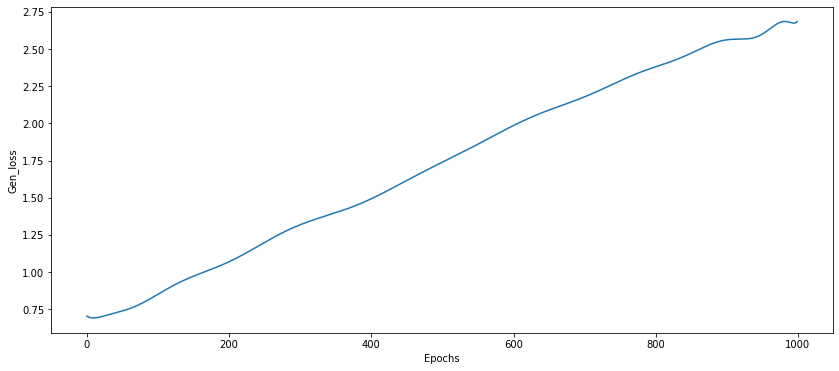

In [179]:
#Wykres funkcji dla generatora 
genl = np.polyfit(epochs_list,g_loss_list,25)
poly_y = np.poly1d(genl)(epochs_list)
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(epochs_list,poly_y)
plt.xlabel('Epochs')
plt.ylabel('Gen_loss')

C:\anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0, 0.5, 'Disc_loss')

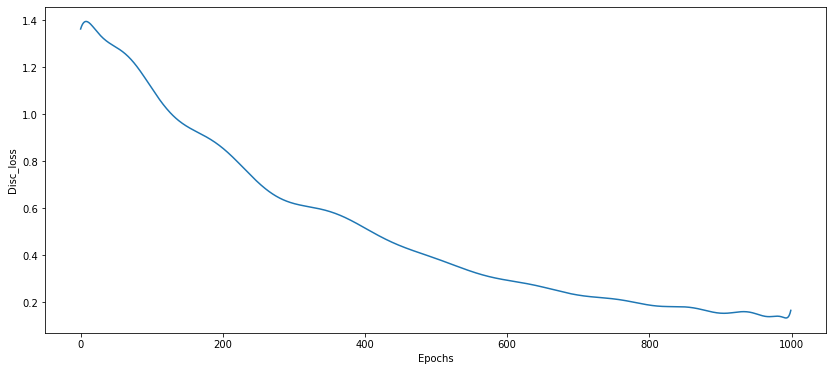

In [180]:
#Wykres funkcji dla dyskryminatora
disl = np.polyfit(epochs_list,d_loss_list,35)
poly_y1 = np.poly1d(disl)(epochs_list)
plt.rcParams["figure.figsize"] = (14,6)
plt.plot(epochs_list,poly_y1)
plt.xlabel('Epochs')
plt.ylabel('Disc_loss')

In [85]:
generator.save('C:/Users/komej/srmodels/GEN203-4x.h5')

C:\anaconda3\envs\keras\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [4]:
generator=load_model('C:/Users/komej/srmodels/GEN190v3-2x.h5',compile=False,custom_objects={'LeakyReLU':tf.keras.layers.LeakyReLU})

In [ ]:
tf.keras.utils.plot_model(discriminator,to_file='C:/Users/komej/srmodels/model.png',show_shapes=True,show_dtype=True)

(1, 500, 750, 3)


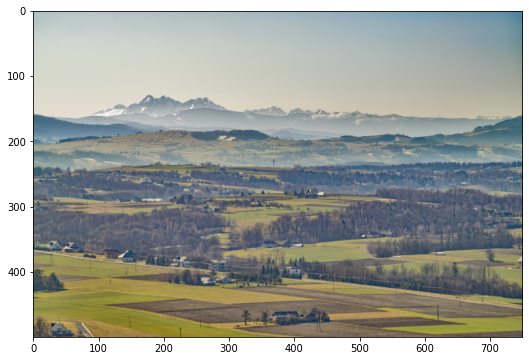

In [167]:
test_path='C:/Users/komej/test1.jpg'
i=cv2.imread(test_path)
i=cv2.resize(i,(750,500),interpolation=cv2.INTER_AREA)
#i=cv2.GaussianBlur(i,(3,3),0)
#i=cv2.cvtColor(i,cv2.COLOR_BGR2RGB)
i=np.array(i)/127.5-1
i=i.astype('float32')
#i=cv2.bilateralFilter(i,3,25,25)
#i=preprocess_input_inc(i)
i=np.expand_dims(i,axis=0)
print(i.shape)
imgplot=plt.imshow(i[0])

In [164]:
score=generator.predict(i)
score=score[0,:,:,:]

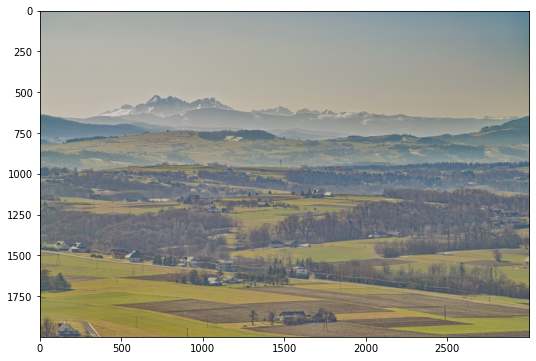

In [165]:
score=cv2.cvtColor(score,cv2.COLOR_BGR2RGB)
score=((score+1)*127.5).astype(np.uint8)
cv2.imwrite('C:/Users/komej/out.png',score)
imgplot=plt.imshow(score)

Text(0.5, 1.0, 'HR')

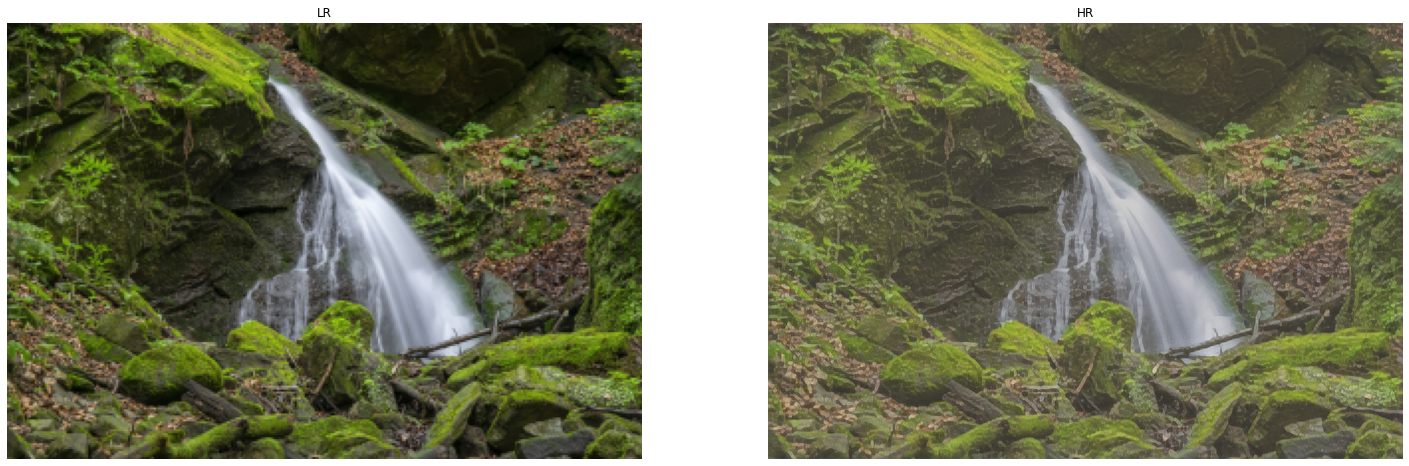

In [138]:
fig = plt.figure(figsize=(25, 20))
fig.add_subplot(2,2,1)
plt.imshow(i[0])
plt.axis('off')
plt.title('LR')
fig.add_subplot(2,2,2)
plt.imshow(score)
plt.axis('off')
plt.title('HR')

Text(0.5, 1.0, 'HR')

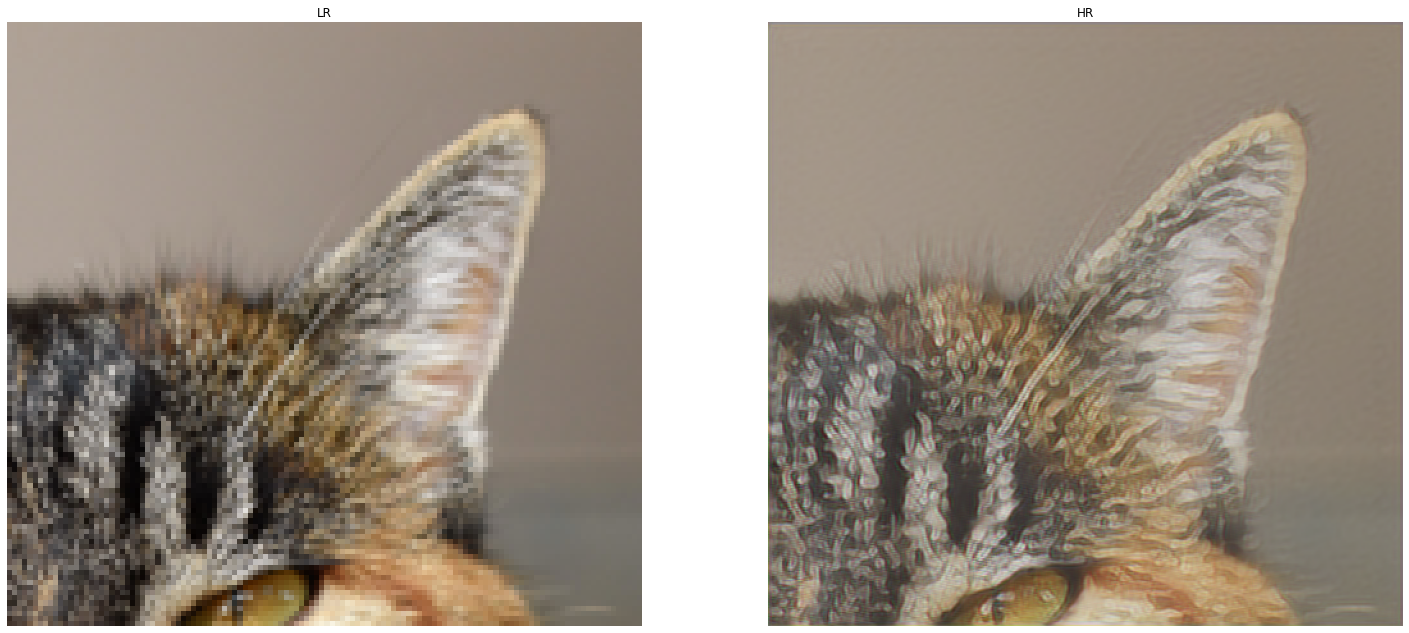

In [150]:
fig = plt.figure(figsize=(25, 25))
fig.add_subplot(2,2,1)
plt.imshow(i[0])
plt.axis('off')
plt.title('LR')
fig.add_subplot(2,2,2)
plt.imshow(score)
plt.axis('off')
plt.title('HR')

Text(0.5, 1.0, 'HR')

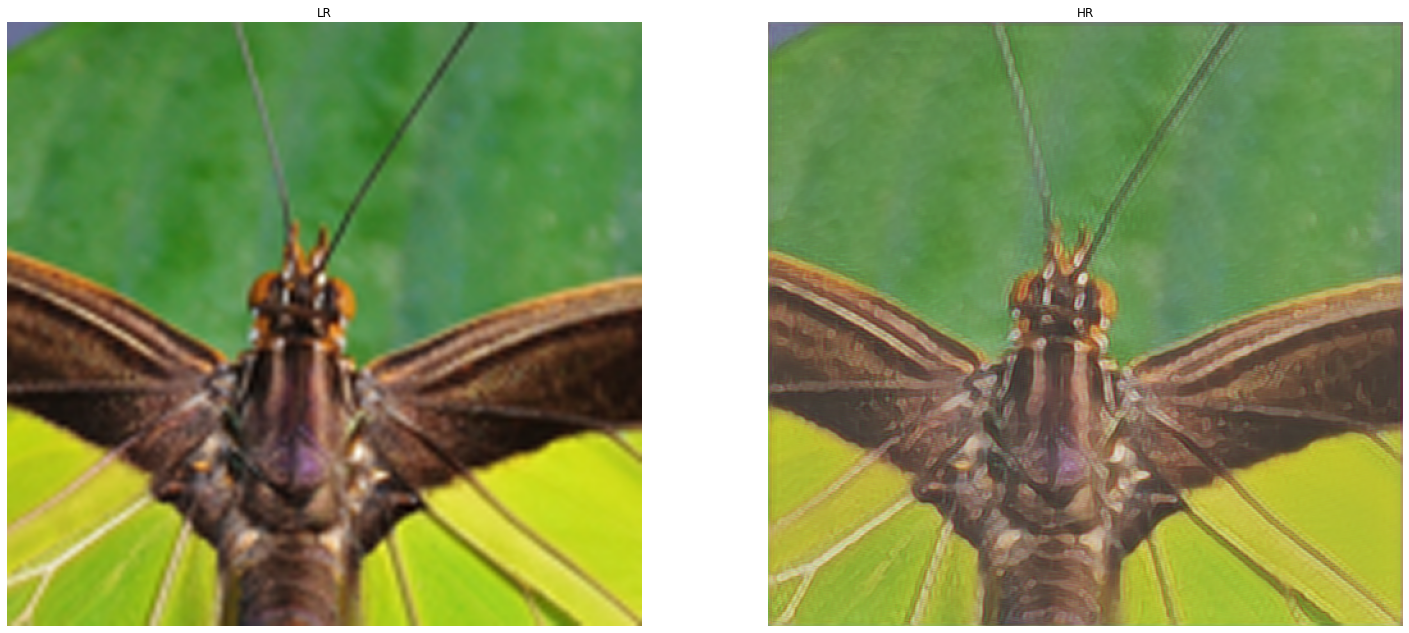

In [159]:
fig = plt.figure(figsize=(25, 25))
fig.add_subplot(2,2,1)
plt.imshow(i[0])
plt.axis('off')
plt.title('LR')
fig.add_subplot(2,2,2)
plt.imshow(score)
plt.axis('off')
plt.title('HR')